# Predicting Who Will Leave and Why - Python Machine Learning

In this notebook, we do a brief exploration of our HR analytics data and try to discern which factors matter the most in determining why our personnel leave. The notebook will primarily be divided into two sections -- data analysis and machine learning. 

## Data Analysis

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Reading in the Data

First, let's read in and get an overview of the data we'll be working with.

In [2]:
hr_data = pd.read_csv('../input/HR_comma_sep.csv')
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
hr_data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [4]:
hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


Conveniently, there is no missing data. Given that the "sales' and "salary" columns are non-numeric, we can check the number of unique levels and dummy code the variables.

In [5]:
print('Departments: ', ', '.join(hr_data['sales'].unique()))
print('Salary levels: ', ', '.join(hr_data['salary'].unique()))

Departments:  sales, accounting, hr, technical, support, management, IT, product_mng, marketing, RandD
Salary levels:  low, medium, high


In [6]:
dummy_depts = pd.get_dummies(hr_data['sales'], drop_first = True)
dummy_salaries = pd.get_dummies(hr_data['salary'], drop_first = True)

In [7]:
hr_data_new = hr_data.drop(['sales','salary'], axis = 1)
hr_data_new = hr_data_new.join(dummy_depts)
hr_data_new = hr_data_new.join(dummy_salaries)
hr_data_new.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,low,medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


Observe that "IT" and "high" are the baseline levels for the assigned department and salary level, respectively. Also note that we saved the data with dummified variables as another dataframe in case we need to access the string values, such as for a cross-tabulation table.

### Exploring the Data

Now that we have data in an analysis-friendly form, we can do some basic visualizations to spot any relationships in the data.

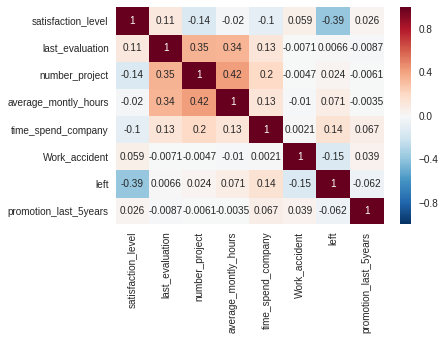

In [8]:
# Correlation matrix
sns.heatmap(hr_data.corr(), annot=True)

The matrix above shows that, generally speaking, the data is not correlated. This is good because it means we likely won't have issues with multicollinearity later.

It is notable, though perhaps unsurprising, that our employees' satisfaction level is the variable that is most highly correlated with them leaving.

In [9]:
hr_data_new.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'RandD', 'accounting', 'hr', 'management',
       'marketing', 'product_mng', 'sales', 'support', 'technical', 'low',
       'medium'],
      dtype='object')

Let's first check if there are any particular departments that our people tend to be leaving from.

In [10]:
dept_table = pd.crosstab(hr_data['sales'], hr_data['left'])
dept_table.index.names = ['Department']
dept_table

left,0,1
Department,,
IT,954,273
RandD,666,121
accounting,563,204
hr,524,215
management,539,91
marketing,655,203
product_mng,704,198
sales,3126,1014
support,1674,555


We can check the above in terms of percentages to more easily see if there are particular departments that tend to have a higher proportion of people leaving.

In [11]:
dept_table_percentages = dept_table.apply(lambda row: (row/row.sum())*100, axis = 1)
dept_table_percentages

left,0,1
Department,,
IT,77.750611,22.249389
RandD,84.625159,15.374841
accounting,73.402868,26.597132
hr,70.906631,29.093369
management,85.555556,14.444444
marketing,76.340326,23.659674
product_mng,78.048780,21.951220
sales,75.507246,24.492754
support,75.100942,24.899058


R&D and management tend to have lower rates of leaving, and HR and accounting tend to have higher rates of leaving. The other departments are fairly similar, all between around 22 to 25 percent. We can also visualize the above data with a countplot.

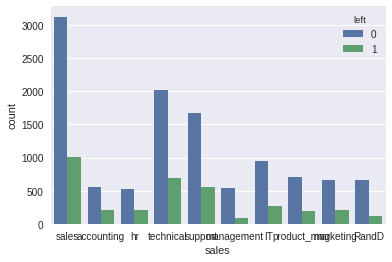

In [12]:
sns.countplot(x='sales', hue='left', data=hr_data)

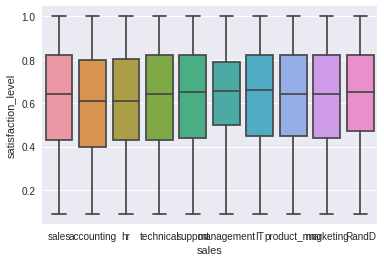

In [13]:
sns.boxplot(x='sales', y='satisfaction_level', data=hr_data)

While there doesn't appear to be too much of a difference in the satisfaction, we notice that both HR and accounting, the departments that have the highest rates of leaving, have slightly lower median satisfaction levels than the rest of the departments.

Salary is likely to have a high impact on leaving. In fact, it is highly likely that both R&D and management, the two departments with the lowers leaving rates, have high salaries. Let's first check the relationship between leaving and salary.

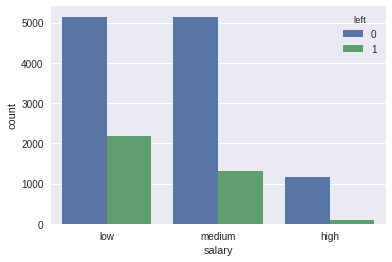

In [14]:
sns.countplot(x='salary', hue='left', data=hr_data)

Confirming our hypothesis, those with low salaries tend to have the highest number of people that leave. Eyeballing the plot shows us that around 40% of those with low salaries leave and 25% of those with median salaries leave. It looks like only 10% of those with high salaries leave.

Let's also check the spread of satisfaction level between the different salary ranges.

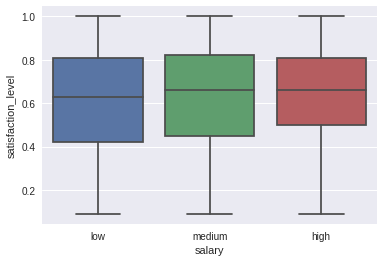

In [15]:
sns.boxplot(x='salary', y='satisfaction_level', data=hr_data)

Again, in line with some of our prior observations, low salary has the lowest median satisfaction and the highest spread.

Something that may impact employee perception in the company is the number of projects they are assigned.

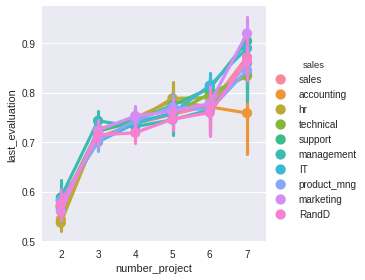

In [16]:
sns.factorplot(x='number_project', y='last_evaluation', hue='sales', data=hr_data)

It is very clear that evaluation scores are affected by the number of projects assigned to the employee. What's more, we again notice a peculiar trend in accounting -- they have a lower last_evaluation score than the other departments at 7 projects.

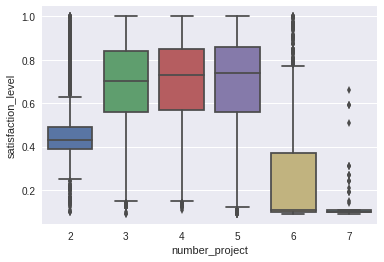

In [17]:
sns.boxplot(x='number_project', y='satisfaction_level', data=hr_data_new)

It looks like we've found a very important relationship -- those with high numbers of projects (6 or 7) tend to have *extremely* low satisfaction levels. This will likely play a role when we do our modeling. Also worth noting is that those with only 2 projects tend to also have lower satisfaction levels.

Let's take a look at time spent at the company and the effect of that on leaving. It was the third most correlated factor with leaving, so this should give us some usable information. We also check this in the context of two of the variables we previously studied, salary and department, to see if there are additional insights we can extract.

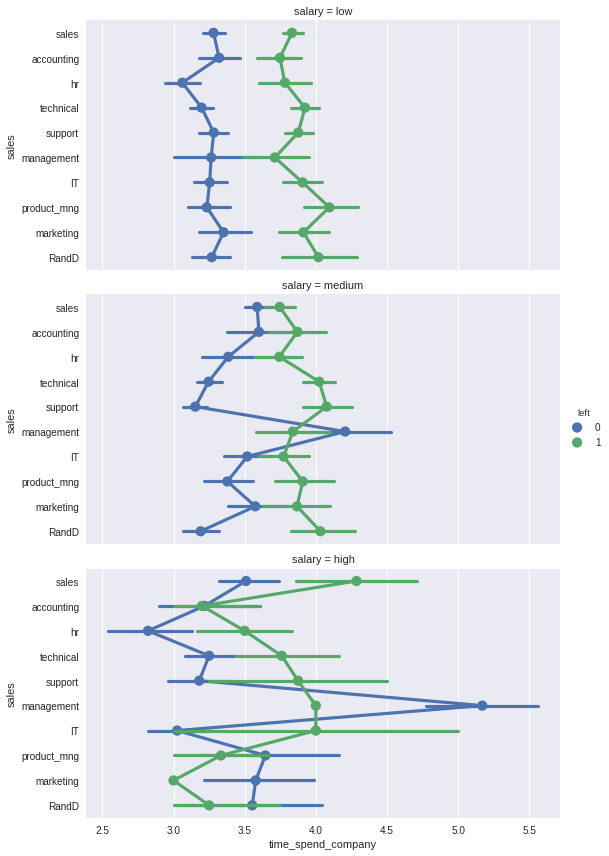

In [18]:
timeplot = sns.factorplot(x='time_spend_company', hue='left', y='sales', row='salary', data=hr_data, aspect=2)

There is a clear trend for those with low and medium salaries -- those that leave tend to have spent more time at the company. For those with high salaries, leaving depends on the department. At the high salary level, time spent doesn't vary in accounting for those that left versus those that haven't but it varies pretty wildly for the support and IT departments.

Before we move on to the modeling section, let's take a look at accidents. This was the second most correlated factor with leaving, interestingly enough.

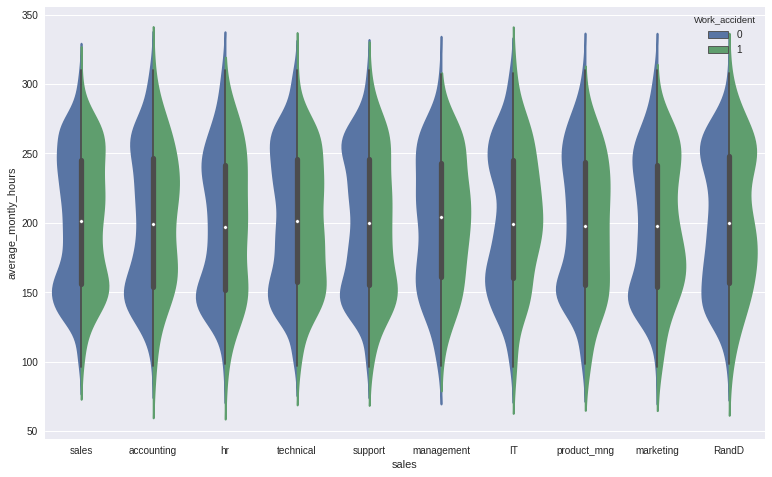

In [19]:
accidentplot = plt.figure(figsize=(10,6))
accidentplotax = accidentplot.add_axes([0,0,1,1])
accidentplotax = sns.violinplot(x='sales', y='average_montly_hours', hue='Work_accident', split=True, data = hr_data, jitter = 0.47)

The difference is quite subtle, but the monthly hours (just noticed when I made this plot that the variable was spelled wrong in the dataset) seems to be bimodally distributed more often for those without work accidents versus those with.

Let's check a similar plot to see the relationship between leaving, work accidents, and satisfaction level.Let's check a similar plot to see the relationship between leaving, work accidents, and satisfaction level.

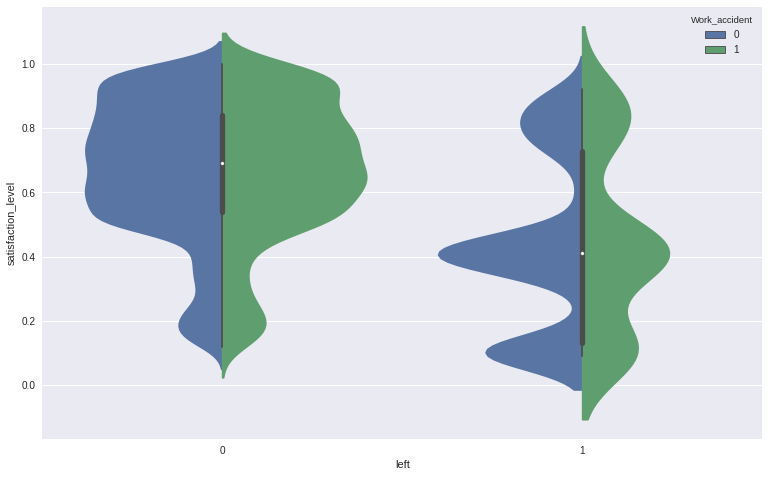

In [20]:
satisaccident = plt.figure(figsize=(10,6))
satisaccidentax = satisaccident.add_axes([0,0,1,1])
satisaccidentax = sns.violinplot(x='left', hue='Work_accident', y='satisfaction_level', split=True, data=hr_data)

What we see here is that there is a marked difference in the satisfaction level spreads of those that leave versus those that don't, with the peaks for those that left being slightly more pronounced for those that have not had workplace accidents, interestingly enough.

## Machine Learning

### Modeling

Let's model the data with a decision tree.

In [21]:
# We now use model_selection instead of cross_validation
from sklearn.model_selection import train_test_split

X = hr_data_new.drop('left', axis=1)
y = hr_data_new['left']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 47)

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

While we will, of course, make predictions on our test set, we treat that as a holdout set and first do some cross-validation on our training set.

In [23]:
from sklearn.model_selection import cross_val_score

# Score first on our training data
print('Score: ', dt.score(X_train, y_train))
print('Cross validation score, 10-fold cv: \n', cross_val_score(dt, X_train, y_train, cv=10))
print('Mean cross validation score: ', cross_val_score(dt,X_train,y_train,cv=10).mean())

Score:  1.0
Cross validation score, 10-fold cv: 
 [ 0.97335871  0.97526166  0.96479543  0.98571429  0.97047619  0.96857143
  0.97521449  0.97902765  0.9742612   0.9742612 ]
Mean cross validation score:  0.973236083013


Our results are very good; showing a consistently high score for all folds of our 10-fold cross-validation using the training data. Let's make predictions and check the performance of the model on the holdout set in the same manner.

In [28]:
predictions = dt.predict(X_test)

print('Score: ', dt.score(X_test, y_test))
print('Cross validation score, 10-fold cv: \n', cross_val_score(dt, X, y, cv=10))
print('Mean cross validation score: ', cross_val_score(dt,X,y,cv=10).mean())

Score:  0.978444444444
Cross validation score, 10-fold cv: 
 [ 0.98467688  0.98533333  0.97        0.96733333  0.96266667  0.98
  0.98933333  0.99333333  1.          1.        ]
Mean cross validation score:  0.982667865867


Once again, the model performs very well. Let's check on some additional classification metrics to see, in more detail, how our model does.

### Evaluation

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion matrix: \n', confusion_matrix(y_test, predictions), '\n')
print('Classification report: \n', classification_report(y_test, predictions))

Confusion matrix: 
 [[3376   66]
 [  31 1027]] 

Classification report: 
              precision    recall  f1-score   support

          0       0.99      0.98      0.99      3442
          1       0.94      0.97      0.95      1058

avg / total       0.98      0.98      0.98      4500



On the basis of our 4500 test samples, our model is very accurate, with only 98 test cases wrong (or only around 2.2% wrong).

Let's check the most important features, or those that are most influential in determining whether an employees leaves (or stays) in our company.

In [26]:
importances = dt.feature_importances_
print("Feature importances: \n")
for f in range(len(X.columns)):
    print('•', X.columns[f], ":", importances[f])

Feature importances: 

• satisfaction_level : 0.498557348042
• last_evaluation : 0.146097441186
• number_project : 0.105209372194
• average_montly_hours : 0.095185043867
• time_spend_company : 0.139192397943
• Work_accident : 0.00141807675753
• promotion_last_5years : 2.77026346326e-05
• RandD : 0.000739590339679
• accounting : 0.000897045698658
• hr : 0.000364477675798
• management : 0.000610885472822
• marketing : 0.000710355492687
• product_mng : 0.000515881952772
• sales : 0.000872030407945
• support : 0.000508757855323
• technical : 0.00134774532348
• low : 0.00504290603983
• medium : 0.00270294111658


To make it easier to interpret, we can order these from most important to least.

In [27]:
featureswithimportances = list(zip(X.columns, importances))
featureswithimportances.sort(key = lambda f: f[1], reverse=True)

print('Ordered feature importances: \n', '(From most important to least important)\n')

for f in range(len(featureswithimportances)):
    print(f+1,". ", featureswithimportances[f][0], ": ", featureswithimportances[f][1])

Ordered feature importances: 
 (From most important to least important)

1 .  satisfaction_level :  0.498557348042
2 .  last_evaluation :  0.146097441186
3 .  time_spend_company :  0.139192397943
4 .  number_project :  0.105209372194
5 .  average_montly_hours :  0.095185043867
6 .  low :  0.00504290603983
7 .  medium :  0.00270294111658
8 .  Work_accident :  0.00141807675753
9 .  technical :  0.00134774532348
10 .  accounting :  0.000897045698658
11 .  sales :  0.000872030407945
12 .  RandD :  0.000739590339679
13 .  marketing :  0.000710355492687
14 .  management :  0.000610885472822
15 .  product_mng :  0.000515881952772
16 .  support :  0.000508757855323
17 .  hr :  0.000364477675798
18 .  promotion_last_5years :  2.77026346326e-05


Most of the variables we studied a while ago, including satisfaction_level, last_evaluation, time_spend_company, number_project, and average_montly_hours, appear to be important. By studying the relationships of these variables between those who have left and those who haven't, we can more accurately determine who's leaving and why.

Interestingly, both salary and department appeared to have a relatively small effect in our decision tree model. This could be caused by the fact that the preceding 5 factors already more accurately describe the conditions of the person who will leave, regardless of department, or the fact that the preceding 5 factors are already strongly correlated enough with salary and/or department to reduce their importance in our final model.

## Conclusion

It's definitely worth taking our employees' satisfaction levels more seriously. We've discovered that this is related to, among other things, their salary and the number of projects they have. Further study could lead to finding an optimal combination of salary, number of projects, and other important factors in taking care of our people that could lead to better performance and profits for us and a lower employee mortality rate. It's also worth noting that time spent at the company and employee evaluations also have an important effect on whether employees leave or not -- this could ultimately be connected to their work, so it's worth investigating in more detail how departments handle project delegation to their employees and what kinds of projects they're given, especially given that those from HR and accounting tend to have higher leave rates than the other functions.